In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8

## Part 1. Data Exploration and Loading

The first issue we see with the data is that files are too big to load and transform in my machine.
We are going to perform a random sampling while reading to comfortably deal with the data. If we are to put the model into production, we can scale up our compute power, but for this PoC a sample of the data should suffice.

In [2]:
from utils import read_csv_sample

In [161]:
march_2017 = read_csv_sample("yellow_tripdata_2017-03.csv", 0.1)
june_2017 = read_csv_sample("yellow_tripdata_2017-06.csv", 0.1)
november_2017 = read_csv_sample("yellow_tripdata_2017-11.csv", 0.1)
dataset = pd.concat([march_2017, june_2017, november_2017]).reset_index(drop=True)

Filename: yellow_tripdata_2017-03.csv
Total number of rows: 10294629
Reading: 1029462
Filename: yellow_tripdata_2017-06.csv
Total number of rows: 9656994
Reading: 965699
Filename: yellow_tripdata_2017-11.csv
Total number of rows: 9284804
Reading: 928480


## Part 2. Data Summary.

In [162]:
# We see there are not apparent null values in our dataset. We will investigate though.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2923640 entries, 0 to 2923639
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   RatecodeID             int64  
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
dtypes: float64(8), int64(6), object(3)
memory usage: 379.2+ MB


In [260]:
dataset.describe()

,passenger_count,trip_distance,tip_amount,toll_yorn,total_amount_minus_tip,duration,extra_0.0,extra_0.5,extra_1.0,pickup_day_week_0,pickup_day_week_1,pickup_day_week_2,pickup_day_week_3,pickup_day_week_4,pickup_day_week_5,pickup_day_week_6,time_of_day_afternoon,time_of_day_morning,time_of_day_night,time_of_day_noon
count,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000,1985502.000
mean,1.604,3.065,2.760,0.060,15.081,17.279,0.517,0.321,0.161,0.123,0.127,0.161,0.175,0.163,0.135,0.116,0.240,0.216,0.226,0.285
std,1.255,3.809,2.814,0.238,12.853,55.348,0.500,0.467,0.368,0.329,0.333,0.368,0.380,0.369,0.341,0.321,0.427,0.411,0.418,0.451
min,0.000,0.000,-15.840,0.000,-54.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.350,0.000,7.800,7.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,1.700,2.000,0.000,10.800,11.800,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2.000,3.200,3.060,0.000,16.300,19.300,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,9.000,116.900,376.790,1.000,500.000,1439.983,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [164]:
#We see a strong correlation of tip with trip distance and total amount. This is expected. 
#It is quite possible that the Credit card machine gives an option to add a tip proportional (linear) to the total fare amount.
#This could be adding a great bias by default. Also cultural rules can add a bias into the tip that is paid. 
dataset.corr()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
VendorID,1.000000,0.269243,0.020723,0.001340,-0.020052,-0.015102,-0.022841,-0.000130,0.002105,-0.000616,0.015533,0.006457,-0.020400,0.000029
passenger_count,0.269243,1.000000,0.014409,-0.006276,-0.006475,-0.006251,0.009140,0.000072,0.004191,0.001725,-0.001981,0.007345,-0.004297,0.000106
trip_distance,0.020723,0.014409,1.000000,0.227387,-0.081802,-0.090206,-0.052909,0.029352,0.097797,-0.018050,0.542268,0.445189,0.015785,0.035830
RatecodeID,0.001340,-0.006276,0.227387,1.000000,-0.002616,-0.000738,-0.003806,0.009825,0.025048,-0.278146,0.180926,0.176717,-0.075487,0.012091
PULocationID,-0.020052,-0.006475,-0.081802,-0.002616,1.000000,0.111844,-0.008766,-0.002342,-0.016233,-0.003732,-0.036381,-0.028130,-0.003007,-0.002781
DOLocationID,-0.015102,-0.006251,-0.090206,-0.000738,0.111844,1.000000,-0.007212,-0.002753,-0.019696,0.028171,-0.045504,-0.036660,-0.001920,-0.003305
payment_type,-0.022841,0.009140,-0.052909,-0.003806,-0.008766,-0.007212,1.000000,-0.001112,-0.020198,-0.036002,-0.474323,-0.027440,-0.082867,-0.004714
fare_amount,-0.000130,0.000072,0.029352,0.009825,-0.002342,-0.002753,-0.001112,1.000000,0.002590,0.007338,0.017744,0.013741,0.000888,0.999944
extra,0.002105,0.004191,0.097797,0.025048,-0.016233,-0.019696,-0.020198,0.002590,1.000000,0.034518,0.070386,0.039482,0.033868,0.004572
mta_tax,-0.000616,0.001725,-0.018050,-0.278146,-0.003732,0.028171,-0.036002,0.007338,0.034518,1.000000,-0.102829,-0.162468,0.419289,0.005895


In [165]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
1,2,2017-03-01 00:00:08,2017-03-01 00:25:29,1,14.90,1,N,132,226,1,41.5,0.5,0.5,7.20,0.0,0.3,50.00
2,2,2017-03-01 00:00:10,2017-03-01 00:15:02,1,4.33,1,N,170,24,1,14.5,0.5,0.5,3.16,0.0,0.3,18.96
3,2,2017-03-01 00:00:20,2017-03-01 00:09:15,2,2.28,1,N,162,114,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96
4,1,2017-03-01 00:00:27,2017-03-01 00:22:25,1,4.20,1,N,249,162,1,17.0,0.5,0.5,3.65,0.0,0.3,21.95


As our final product will consist of a model that predicts tip amounts and we only have this information for credit card transactions, we will filter out the rest. This would create a bias towards customers that pay with credit card (maybe younger and more educated folks) but  should not be a problem since our app would hopefully work using only card payments.

In [166]:
dataset = dataset[dataset['payment_type'] == 1].reset_index(drop=True)

In [167]:
#Let's see the distribution of our label (Tip amount)
pd.qcut(dataset.tip_amount, 7).value_counts().sort_index()

(-15.841, 1.0]    326626
(1.0, 1.46]       264533
(1.46, 1.85]      261011
(1.85, 2.2]       293519
(2.2, 2.94]       272540
(2.94, 4.35]      285630
(4.35, 376.79]    281643
Name: tip_amount, dtype: int64

C:\Users\josep\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

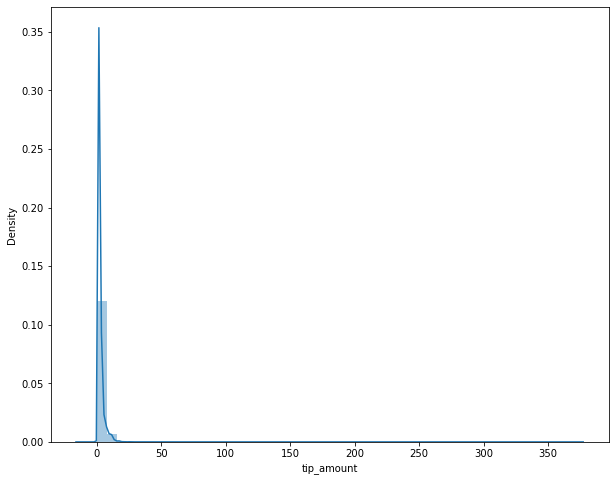

In [168]:
#We see that our label has a quite clear long tail distribution 
sns.distplot(dataset.tip_amount)

In [169]:
#It's quite common to give round numbers as 0, 1, 2, 3 dollars. This can be a good suggestion for product development (suggest rounded amounts of output of model)
dataset.tip_amount.value_counts().iloc[:20]

1.00    178171
2.00     94300
0.00     82848
1.50     37997
3.00     31071
1.95     27605
1.56     27268
1.66     27146
1.46     27120
1.45     26584
1.36     26485
1.76     26385
1.86     25488
1.55     25252
1.96     24486
1.26     23969
2.06     23341
2.45     23057
1.25     23026
1.20     22932
Name: tip_amount, dtype: int64

In [170]:
#passanger_count
dataset['passenger_count'].value_counts().sort_index()

0       3499
1    1438657
2     279381
3      77940
4      33747
5      94927
6      57335
7          5
8          7
9          4
Name: passenger_count, dtype: int64

<AxesSubplot:>

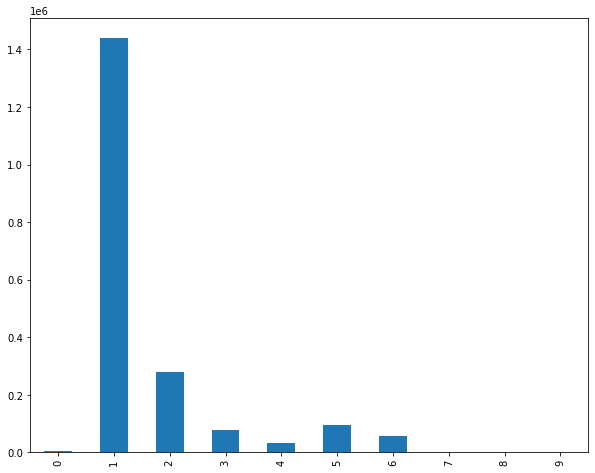

In [171]:
#This is a manually entered value by the driver and most likely the default is 1. I do not trust this feature to express 100% true info.
#On the other hand, there could be some impact from it, since it's intuitive that when traveling with more people,
#the burden of paying a tip could feel less problematic.
dataset['passenger_count'].value_counts().sort_index().plot(kind='bar')

Let's analyze the trips using the time columns. 
For this let's create a feature to get the day of the week for a pickup.
We can check what are the peak hours for a weekday and a weekend day.

In [192]:
dataset['tpep_pickup_datetime'] = pd.to_datetime(dataset['tpep_pickup_datetime'])
dataset['tpep_dropoff_datetime'] = pd.to_datetime(dataset['tpep_dropoff_datetime'])

In [174]:
dataset['pickup_day_week'] = dataset['tpep_pickup_datetime'].apply(lambda x: x.dayofweek)

<AxesSubplot:xlabel='pickup_day_week'>

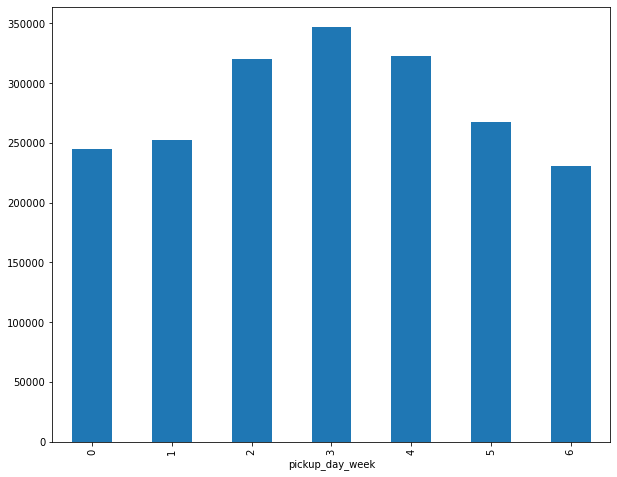

In [175]:
#0 is monday and 6 is Sunday.
dataset[["pickup_day_week", "VendorID"]].groupby("pickup_day_week").size().plot(kind="bar")

#It's interesting and perhaps non intuitive to see that the most active days are from Wed to Fri.

In [176]:
dataset["pickup_hour"] = dataset['tpep_pickup_datetime'].dt.hour
dataset["pickup_minute"] = dataset['tpep_pickup_datetime'].dt.minute

We can see in the plot below that on average there is a rapid rise in pickups starting at around 5 am until 10 am. 
Then it keeps aproximately constant until around 17h-19h, which are the maximum peak hours, and from there there is a decline reaching minimums, again, at around 5 

<AxesSubplot:xlabel='pickup_hour,pickup_minute'>

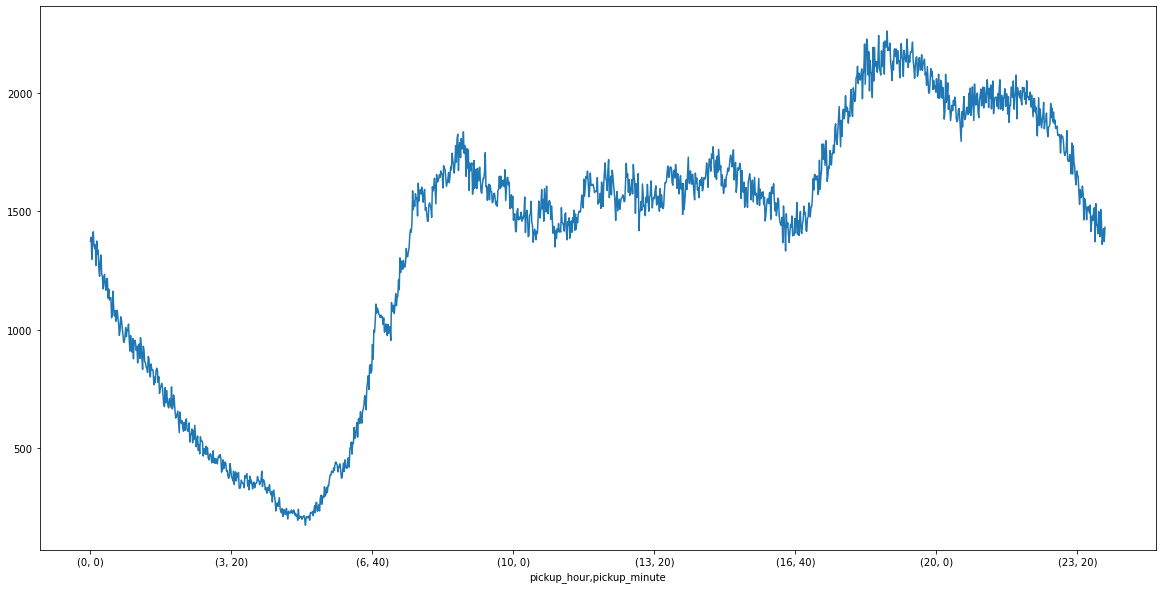

In [177]:
dataset.groupby([dataset["pickup_hour"] , dataset["pickup_minute"]]).VendorID.size().plot(figsize=(20,10))

<AxesSubplot:xlabel='pickup_hour,pickup_minute'>

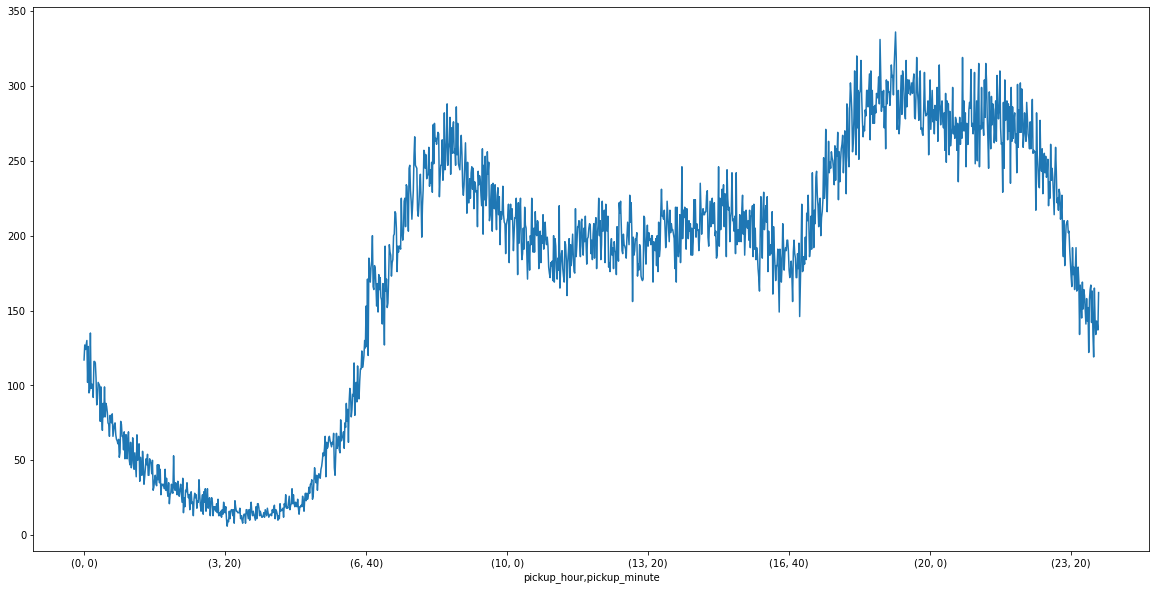

In [178]:
#For tuesdays. The signal is noisier since we are aggregating less data per minute.
dataset[dataset['pickup_day_week']== 1].groupby([dataset["pickup_hour"] , dataset["pickup_minute"]]).VendorID.size().plot(figsize=(20,10))

<AxesSubplot:xlabel='pickup_hour,pickup_minute'>

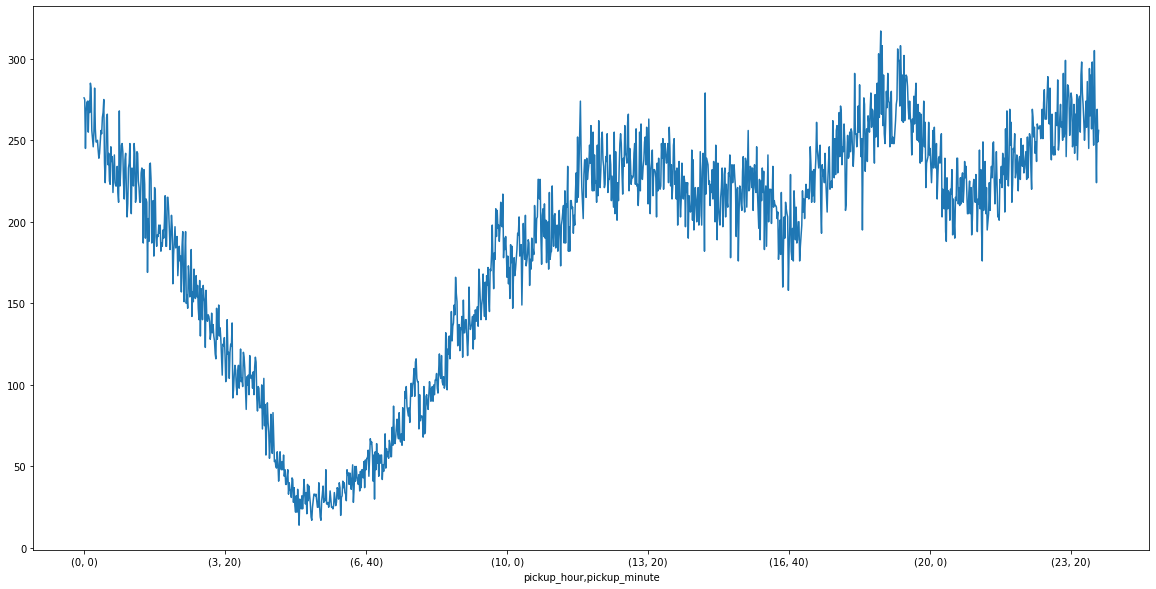

In [179]:
#For Saturdays we can see a different pattern, consistent with intuition
dataset[dataset['pickup_day_week']== 5].groupby([dataset["pickup_hour"] , dataset["pickup_minute"]]).VendorID.size().plot(figsize=(20,10))

C:\Users\josep\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

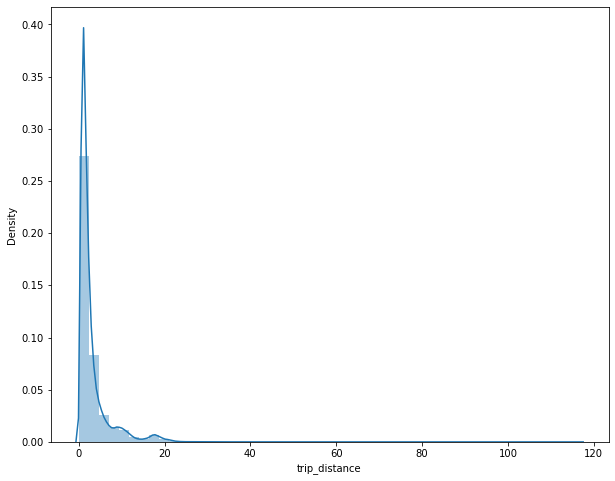

In [180]:
sns.distplot(dataset['trip_distance'])
#We see in this plot that most trips are between 0 and 20 miles long. Similar long tail as with tips and fares. Let's zoom in.

C:\Users\josep\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

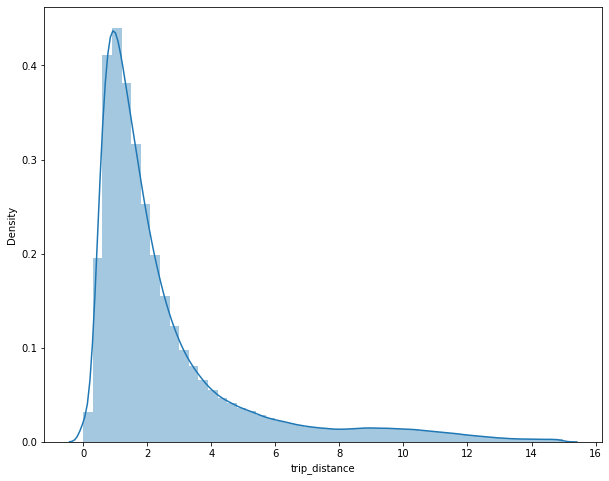

In [181]:
sns.distplot(dataset[dataset['trip_distance']<15].trip_distance)

## Part 3. Modeling.

In [182]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day_week,pickup_hour,pickup_minute
0,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12,3,22,1
1,2,2017-03-01 00:00:08,2017-03-01 00:25:29,1,14.90,1,N,132,226,1,41.5,0.5,0.5,7.20,0.0,0.3,50.00,2,0,0
2,2,2017-03-01 00:00:10,2017-03-01 00:15:02,1,4.33,1,N,170,24,1,14.5,0.5,0.5,3.16,0.0,0.3,18.96,2,0,0
3,2,2017-03-01 00:00:20,2017-03-01 00:09:15,2,2.28,1,N,162,114,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96,2,0,0
4,1,2017-03-01 00:00:27,2017-03-01 00:22:25,1,4.20,1,N,249,162,1,17.0,0.5,0.5,3.65,0.0,0.3,21.95,2,0,0


Let's start by dropping columns we will not need, either because they are not related to our problem or because the distribution is too skewed.

In [184]:
cols_to_drop = ["VendorID", 
                "RatecodeID", 
                "store_and_fwd_flag", 
                "payment_type", 
                "improvement_surcharge", 
                "mta_tax",
                "fare_amount", #we will keep total_amount - tips. 
                "pickup_minute",
                "DOLocationID",
                "PULocationID"]
#It would be interesting to try to find a data source to map these 2 Location codes to actual locations, and demographic data 
#but given the time constraint of the exercise we will leave it for further analysis.

In [185]:
dataset = dataset.drop(cols_to_drop, axis=1)

In [186]:
dataset.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,extra,tip_amount,tolls_amount,total_amount,pickup_day_week,pickup_hour
0,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,0.5,2.82,0.0,14.12,3,22
1,2017-03-01 00:00:08,2017-03-01 00:25:29,1,14.90,0.5,7.20,0.0,50.00,2,0
2,2017-03-01 00:00:10,2017-03-01 00:15:02,1,4.33,0.5,3.16,0.0,18.96,2,0
3,2017-03-01 00:00:20,2017-03-01 00:09:15,2,2.28,0.5,2.16,0.0,12.96,2,0
4,2017-03-01 00:00:27,2017-03-01 00:22:25,1,4.20,0.5,3.65,0.0,21.95,2,0


### Feature engineering

In [187]:
dataset['toll_yorn'] = np.where(dataset['tolls_amount'] > 0, 1, 0)

Most of the fares have no tolls. In order to keep some of this information but make the analysis simpler
we will set a flag to 1 if there is a toll and 0 if not.

In [188]:
dataset['extra'].value_counts()

 0.00    1019003
 0.50     638022
 1.00     320146
 4.50       8317
 1.50          4
 2.00          2
 0.40          1
-6.60          1
 1.01          1
 7.06          1
 0.02          1
 4.54          1
 0.30          1
 2.50          1
Name: extra, dtype: int64

The extra is by definition surcharges on rush hour (0.5) and night(1). 
It could be interesting to keep it as a categorical feature (since each extra means something) 
to see if it affects the willingness to give a tip.

In [189]:
#We clean the wrong (by definition) applied extra charges
dataset['extra'] = dataset['extra'].apply(lambda x: x if x in (0, 0.5, 1) else 0)

In [190]:
#Let's consider the fare amount as the total amount - Tip in order to simplify and be able to drop 1 column
dataset['total_amount_minus_tip'] = dataset['total_amount'] - dataset['tip_amount']

In [193]:
#Let's calculate ride duration. Too slow or too fast rides could have positive/negative impact in tips.
dataset['duration'] = (dataset['tpep_dropoff_datetime'] - dataset['tpep_pickup_datetime']).apply(lambda x: (x.seconds)/60)

In [194]:
cols_to_drop = ["total_amount",
                "tpep_pickup_datetime",
                "tpep_dropoff_datetime",
                "tolls_amount"]

In [195]:
dataset = dataset.drop(cols_to_drop, axis = 1)

In [196]:
#We divide pickup hours in different times of the day in accordance with the different time patterns we saw in the graphs above.
bins = [0, 4, 10, 16, 20, 23]
tags = ["night", "morning", "noon", "afternoon", "night"]
dataset["time_of_day"] = pd.cut(dataset["pickup_hour"], 
                                bins=bins, 
                                labels=tags, 
                                ordered=False)

dataset = dataset.drop("pickup_hour", axis=1)

In [197]:
dataset

,passenger_count,trip_distance,extra,tip_amount,pickup_day_week,toll_yorn,total_amount_minus_tip,duration,time_of_day
0,1,2.27,0.5,2.82,3,0,11.30,10.133333,night
1,1,14.90,0.5,7.20,2,0,42.80,25.350000,NaN
2,1,4.33,0.5,3.16,2,0,15.80,14.866667,NaN
3,2,2.28,0.5,2.16,2,0,10.80,8.916667,NaN
4,1,4.20,0.5,3.65,2,0,18.30,21.966667,NaN
...,...,...,...,...,...,...,...,...,...
1985497,2,6.50,0.5,5.00,3,1,30.06,25.616667,night
1985498,2,1.20,0.5,2.00,3,0,13.30,18.783333,night
1985499,1,5.44,0.5,8.04,3,0,26.80,34.416667,night
1985500,1,1.57,0.5,1.76,4,0,8.80,7.566667,NaN


### Data Preparation

In [198]:
#Categorical columns need to be transformed into one hot econded columns.
categorical_columns = ["extra", #We want to encode different types of extras
                       "pickup_day_week",
                       "time_of_day"
                      ]

In [199]:
#We use get_dummies for this PoC, in order to get One Hot Encoded variables.
dataset = pd.get_dummies(dataset, prefix=categorical_columns, columns=categorical_columns)

In [200]:
dataset

,passenger_count,trip_distance,tip_amount,toll_yorn,total_amount_minus_tip,duration,extra_0.0,extra_0.5,extra_1.0,pickup_day_week_0,pickup_day_week_1,pickup_day_week_2,pickup_day_week_3,pickup_day_week_4,pickup_day_week_5,pickup_day_week_6,time_of_day_afternoon,time_of_day_morning,time_of_day_night,time_of_day_noon
0,1,2.27,2.82,0,11.30,10.133333,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,1,14.90,7.20,0,42.80,25.350000,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,1,4.33,3.16,0,15.80,14.866667,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,2,2.28,2.16,0,10.80,8.916667,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,1,4.20,3.65,0,18.30,21.966667,0,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985497,2,6.50,5.00,1,30.06,25.616667,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1985498,2,1.20,2.00,0,13.30,18.783333,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1985499,1,5.44,8.04,0,26.80,34.416667,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1985500,1,1.57,1.76,0,8.80,7.566667,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [201]:
y = dataset['tip_amount']
X = dataset.drop('tip_amount', axis=1)

In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Model Fitting

We have decided to go for Linear regression for several reasons:
 - The problem is close to being considered a linear one. Usually customers give a proportion of their trip to the driver as a tip
 - We have big amounts of data and my machine is not being very powerful. It should suffice.
 - We get the coefficients which tell us the feature importance of our model. 
 - A simple model is sometimes the better option. There are less parameters to take into account.

In [243]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [244]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [254]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

In [261]:
rmse

1.7043481637547444

The root mean squared error is the metric we chose for assessing the performance of the model. 
We could probably get a better metric if we drop outliers and tips==0. For the purposes of this PoC 1.7$ seems to be an acceptable RMSE.
This error function penalizes the big errors more than others as Mean Absolute Error

In [258]:
rmse_train

1.8488487752754672

We do not see signs of overfitting

In [252]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)


The coefficient tells us that the tip comes mostly from multiplying the total_amount times 0.12 (12% of the total amount).
This is what we thought at the beggining. The norm in NYC is to give from 10 to 20 percent of the total amount to the driver as a tip.

In [259]:
coefficients

,0,0
0,passenger_count,-0.001
1,trip_distance,0.124
2,toll_yorn,0.886
3,total_amount_minus_tip,0.121
4,duration,-0.000
5,extra_0.0,0.003
6,extra_0.5,-0.012
7,extra_1.0,0.009
8,pickup_day_week_0,0.000
9,pickup_day_week_1,0.037


We could improve our model by removing people that have 0 as their tip. This events of bad service or different culture cannot be predicted with the variables we have. Also, we could remove some of the features we clearly see have no impact to make the model simpler. 

It would be interesting to add weather data to see if it affects the amount of tip customers are willing to give. We will leave this for a future analysis. 

Of course, this model is not production ready. A proper pipeline needs to be implemented that will allow us to apply the same transformations to our training data as well as new data that comes up in our app. 

Once properly implemented, we can use a tool like MLFlow to register and serve the model as a REST API in the cloud.